## WEEK 6. Оценка эффекта от внедрения полученного решения.

Постройте простую экономическую модель для оценки эффекта от внедрения полученного решения на практике. 

Например, введите следующие параметры:

* сколько денег в среднем приносит один пользователь в месяц;
* сколько денег в среднем вы будете вкладывать в удержание одного пользователя;
* с какой вероятностью пользователь примет ваше предложение;
* сколько пользователей (например, топ 1% или топ 25% согласно ранжированию по вашей модели) будет участвовать в кампании.


1. Введите еще несколько параметров и на их основе постройте простую экономическую модель: формулу по которой в зависимости от значения исходных параметров вы сможете рассчитать экономический эффект от проведения кампании (= сколько денег вы получили (или наоборот потеряли) от проведения кампании по удержанию) с использование вашей модели.

2. Исходя из введенных параметров проанализируйте, какой топ пользователей, склонных к оттоку согласно модели, оптимально выбрать для проведения кампании по удержанию для таким образом, чтобы экономический эффект был наибольшим? 

3. Попробуйте усложнить экономическую модель. Добавьте еще несколько параметров и поиграйте с ними (например, измените стоимость удержания и вероятность, с которой пользователь принимает предложение), проанализируйте как меняется оптимальный размер топа? 

4. Всегда ли применение модели экономически оправданно? Приведите пример набора значений параметров, при которых применение модели перестает быть оправданным.

5. Оцените изменение экономического эффекта от проведения кампании по удержанию при увеличении качества модели на 1%? На 3%? При ответе на вопрос укажите, по какой метрике вы оцениваете качество.

6. Как вы думаете, является ли экономически оправданным вложение средств в улучшение качества модели? На сколько нужно улучшить модель, чтобы это качественно сказалось на экономическом эффекте от удержания?

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn import model_selection, linear_model, metrics, ensemble
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline

Было решено применить модель XGBClassifier вместо GradientBoostingClassifier, так как она показала более высокое качество. Подготовка данных и построение модели приведены ниже (процесс выбора лучшего варианта обработки данных и настройки параметров был аналогичен тому, что сделан на пятой недели, не буду его приводить).

### 1. Подготовка данных

In [2]:
train = pd.read_csv('orange_small_churn_train_data.csv')
test = pd.read_csv('orange_small_churn_test_data.csv')

train = train.drop(18298, axis=0)  #удалим последнюю строку, т.к. в ней почему-то нет данных 

In [3]:
y = train['labels']
X_train = train.drop(['ID', 'labels'],axis=1)
X_test = test.drop(['ID'],axis=1)

In [4]:
data_train = pd.concat([X_train, y], axis=1)

In [5]:
# Oversampling
count_no_outflow, count_outflow = y.value_counts()

df_no_outflow = data_train[data_train['labels'] == -1]
df_outflow = data_train[data_train['labels'] == 1]

df_outflow_under = df_outflow.sample((count_no_outflow - count_outflow), replace=True)
data_oversampling = shuffle(pd.concat([df_no_outflow, df_outflow, df_outflow_under], axis=0))

print('Random over-sampling:')
print(data_oversampling.labels.value_counts())

Random over-sampling:
 1.0    16921
-1.0    16921
Name: labels, dtype: int64


In [6]:
y = data_oversampling.iloc[:,-1]
X_train = data_oversampling.iloc[:,:230]

In [7]:
#пропуски у числовых переменных заполняем нулями, у категориальных - строкой "Na"
X_train_num = X_train.iloc[:, :190].fillna(0) 
X_test_num = X_test.iloc[:, :190].fillna(0)
X_train_cat = X_train.iloc[:, 190:].fillna('Na', axis=0).applymap(str)
X_test_cat = X_test.iloc[:, 190:].fillna('Na', axis=0).applymap(str)

In [8]:
#Преобразуем категориальные переменные через LabelEncoder
from sklearn.preprocessing import LabelEncoder
def labelEncoder(data, test):
    lab_enc = LabelEncoder()
    for one_column in data.columns:
        lab_enc.fit(data.loc[:,one_column].append(test.loc[:,one_column]))
        data.loc[:,one_column] = lab_enc.transform(data.loc[:,one_column])
        test.loc[:,one_column] = lab_enc.transform(test.loc[:,one_column])  
    return data, test

In [9]:
X_train_cat, X_test_cat = labelEncoder(X_train_cat, X_test_cat)

In [10]:
#Объединим признаки в обучающую и тестовую выборки
X_train = pd.DataFrame(np.hstack((X_train_num, X_train_cat)), columns = list(X_train_num.columns)+list(X_train_cat.columns)) 
X_test = pd.DataFrame(np.hstack((X_test_num, X_test_cat)), columns = list(X_test_num.columns)+list(X_test_cat.columns)) 

In [11]:
#Проведем следующий отбор признаков: удалим признаки, у которых одно уникальное значение
def DropFeatures(data):
    good_dataframe = pd.DataFrame([])
    for one_column in data.columns:
        if len(np.unique(data.loc[:,one_column]))>1:
            good_dataframe[str(one_column)] = data.loc[:,one_column]
    return good_dataframe

In [12]:
Common_data = DropFeatures(pd.DataFrame.append(X_train, X_test))
#Разделяем данные на обучение и тест
X_data = Common_data.iloc[:X_train.shape[0],:]
X_hold = Common_data.iloc[X_train.shape[0]:,:]

### 2. Обучение модели и вычисление метрик качества

In [13]:
#Тестовые данные с Kaggle убрали в hold-out dataset, остальные данные разобьем на обучение и тест
X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.2, stratify=y, random_state=0)

In [14]:
#Модель XGBClassifier
xgboost_classifier = xgb.XGBClassifier(n_estimators=130, max_depth=4, random_state=0)

#Создаем скалер для масштабирования обучающей выборки. StandardScaler отнимает среднее и делит на выборочное стандарт.откл.
scaler = StandardScaler()

#создаем pipeline из двух шагов: scaling и XGBClassifier
pipeline = Pipeline(steps = [('scaling', scaler), ('regression', xgboost_classifier)])

#для кросс-валидации будем использовать стратегию StratifiedKFold, делим на 5 фолда, перемешиваем выборку
cv_strategy = model_selection.StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)

In [15]:
xgboost_classifier

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=130, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [149]:
#функция для расчета метрик качества
def metric(pipeline, X, y, cv):
    recall = model_selection.cross_val_score(pipeline, X, y, scoring = 'recall', cv=cv)
    precision = model_selection.cross_val_score(pipeline, X, y, scoring = 'precision', cv=cv)
    F1 = model_selection.cross_val_score(pipeline, X, y, scoring = 'f1', cv=cv)
    ROC_AUC = model_selection.cross_val_score(pipeline, X, y, scoring = 'roc_auc', cv=cv)
    return print("Recall: %s,\nPrecision: %r,\nF1: %f,\nROC-AUC: %g." %(recall.mean(), precision.mean(), F1.mean(), ROC_AUC.mean()))

In [374]:
print ('Качество XGBClassifier:\n')
metric(pipeline, X_train, np.ravel(y_train), cv_strategy)

Качество XGBClassifier:

Recall: 0.8383688495115514,
Precision: 0.7667395471209879,
F1: 0.800928,
ROC-AUC: 0.874113.


In [128]:
#Проверка качества на тестовой выборке

#Масштабирование данных
scaler = StandardScaler()
scaler.fit(X_train)               
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

xgboost_classifier = xgb.XGBClassifier(n_estimators=130, max_depth=4, random_state=0)

xgboost_classifier.fit(X_train, np.ravel(y_train))
predictions = xgboost_classifier.predict(X_test)
metrics.roc_auc_score(y_test, predictions)

0.7990912138449773

### Оценка потенциального экономического эффекта от внедрения полученного решения

Постройте простую экономическую модель для оценки эффекта от внедрения полученного решения на практике. Например, введите следующие параметры: сколько денег в среднем приносит один пользователь в месяц; сколько денег в среднем вы будете вкладывать в удержание одного пользователя; с какой вероятностью пользователь примет ваше предложение; сколько пользователей (например, топ 1% или топ 25% согласно ранжированию по вашей модели) будет участвовать в кампании.

### 1.

Введите еще несколько параметров и на их основе постройте простую экономическую модель: формулу по которой в зависимости от значения исходных параметров вы сможете рассчитать экономический эффект от проведения кампании (= сколько денег вы получили (или наоборот потеряли) от проведения кампании по удержанию) с использование вашей модели.

Введем следующие переменные:
* IOC (Income one customer) = 500р/мес (сколько денег в среднем приносит один пользователь в месяц)
* PR (Priece for hold) = 200р               (сколько денег в среднем будем вкладывать в удержание одного пользователя)
* PA (Probability accept) = 0.5%          (с какой вероятностью пользователь примет наше предложение)
* TP (Top customers) = 10%                 (сколько пользователей согласно ранжированию по модели будет участвовать в кампании)
* TC (True-true churn) - число польз-й, к-ых модель отнесла к классу «отток» и кот-ые действительно собирались уйти
* FC ( False churn) - число польз-й, к-ых модель отнесла к классу «отток», но кот-ые по факту не собирались уходить
* FnoC (False no-churn) – число польз-й, к-ых модель отнесла к классу «не отток», но кот-ые по факту хотят уйти

Экономический эффект **Ef** будем рассчитывать по следующей формуле:

                                     Ef  = (IOC*PA-PR)*TC – PR*FC – IOC*FnoC

### 2.

Исходя из введенных параметров проанализируйте, какой топ пользователей, склонных к оттоку согласно модели, оптимально выбрать для проведения кампании по удержанию для таким образом, чтобы экономический эффект был наибольшим?

In [150]:
xgboost_classifier.fit(X_train, np.ravel(y_train))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=130, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [338]:
#Таблица с результатами модели и с фактическими данными, отсортированная по вероятности оттока пользователей:
y_predict_proba = xgboost_classifier.predict_proba(X_test)[:,1]

data = pd.DataFrame()
data['Fact'] = list(y_test)
data['Prob_Predict'] = y_predict_proba

data.sort_values('Prob_Predict', inplace = True, ascending=False)
data.head()

,Fact,Prob_Predict
4157,1.0,0.945336
787,1.0,0.945336
3811,1.0,0.944178
5373,1.0,0.944178
6152,1.0,0.937559


In [339]:
#Функция для вычисления экономического эффекта
def effect(TP, IOC, PR, PA, data):
    top = int(len(data)*TP)
    data_top = data.iloc[:top,:]
    data_bottom = data.iloc[top:,:]
    ef1 = len(data_top[(data_top.Prob_Predict>0.5) & (data_top.Fact==1)])*(IOC*PA-PR)
    ef2 = len(data_top[(data_top.Prob_Predict>0.5) & (data_top.Fact==-1)])*(-PR)
    ef3 = len(data_top[(data_top.Prob_Predict<0.5) & (data_top.Fact==1)])*(-IOC)
    ef = ef1+ef2+ef3
    return ef

In [344]:
IOC = 500
PR = 200
PA = 0.5

tops = np.arange(0.01, 0.26, 0.01)
effect_top = []
for top in tops:
    effect_top.append(effect(top, IOC, PR, PA, data))

Text(0.5, 1.0, 'Зависимость экономического эффекта от размера топа')

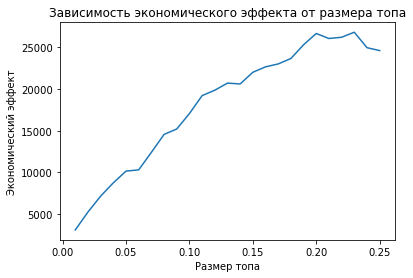

In [345]:
plt.plot(tops, effect_top)
plt.xlabel("Размер топа")
plt.ylabel("Экономический эффект")
plt.title("Зависимость экономического эффекта от размера топа")

##### Из графика видно, что оптимальный размер топа пользователей для выбранных параметров модели равен примерно 23% и экономический эффект составит порядка 27000р.

### 3.

Попробуйте усложнить экономическую модель. Добавьте еще несколько параметров и поиграйте с ними (например, измените стоимость удержания и вероятность, с которой пользователь принимает предложение), проанализируйте как меняется оптимальный размер топа?

Усложним модель через добавление следующих переменных: 
* UC (unexpected cost) - непредвиденные расходы при проведении компании по удержанию на одного пользователя
* PUC (probability unexpected cost) - вероятность возникновения непредвиденного расхода на одного пользователя

In [155]:
def effect2(TP, IOC, PR, PA, UC, PUC):
    top = int(len(data)*TP)
    data_top = data.iloc[:top,:]
    data_bottom = data.iloc[top:,:]
    ef1 = len(data_top[(data_top.Prob_Predict>0.5) & (data_top.Fact==1)])*(IOC*PA-(PR+(UC*PUC)))
    ef2 = len(data_top[(data_top.Prob_Predict>0.5) & (data_top.Fact==-1)])*(-(PR+(UC*PUC)))
    ef3 = len(data_top[(data_top.Prob_Predict<0.5) & (data_top.Fact==1)])*(-IOC)
    ef = ef1+ef2+ef3
    return ef

* Пусть стоимость удержания уменьшится до 150, но при этом не забываем, что мы ввели возможность понести доп.расходы. Посмотрим как поменяется оптимальный топ.

In [156]:
IOC = 500
PR = 150
PA = 0.5
UC = 100
PUC = 0.3

tops = np.arange(0.01, 0.5, 0.01)
effect_top = []
for top in tops:
    effect_top.append(effect2(top, IOC, PR, PA, UC, PUC))

Text(0.5, 1.0, 'Расходы на удержание снизились, но есть доп.расходы')

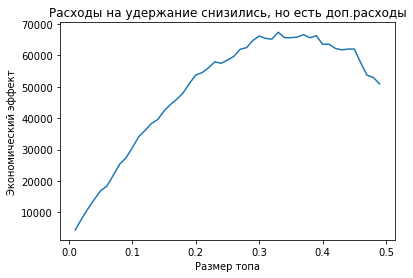

In [157]:
plt.plot(tops, effect_top)
plt.xlabel("Размер топа")
plt.ylabel("Экономический эффект")
plt.title("Расходы на удержание снизились, но есть доп.расходы")

##### Ситуация улучшилась - экономический эффект вырос, оптимальный топ стал около 32%

* Увеличим стоимость удержания и увеличим вероятность принятия предложения клиентом:

In [158]:
IOC = 500
PR = 250
PA = 0.7
UC = 100
PUC = 0.3

tops = np.arange(0.01, 0.5, 0.01)
effect_top = []
for top in tops:
    effect_top.append(effect2(top, IOC, PR, PA, UC, PUC))

Text(0.5, 1.0, 'Расходы на удержание увеличились и есть доп.расходы')

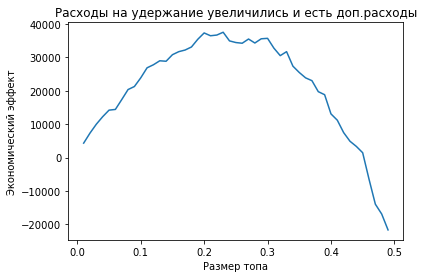

In [159]:
plt.plot(tops, effect_top)
plt.xlabel("Размер топа")
plt.ylabel("Экономический эффект")
plt.title("Расходы на удержание увеличились и есть доп.расходы")

##### При использованных параметрах (IOC = 500, PR = 250, PA = 0.7, UC = 100, PUC = 0.3) оптимальный топ равен примерно 22%

* Увеличим стоимость удержания (по сравнению с изначальным вариантом, где PR=200) и уменьшим вероятность принятия предложения клиентом:

In [160]:
IOC = 500
PR = 250
PA = 0.4
UC = 100
PUC = 0.3

tops = np.arange(0.01, 0.5, 0.01)
effect_top = []
for top in tops:
    effect_top.append(effect2(top, IOC, PR, PA, UC, PUC))

Text(0.5, 1.0, 'Расходы на удержание увеличились и есть доп.расходы')

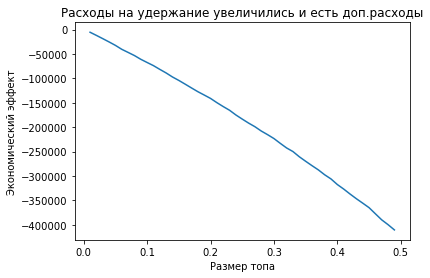

In [161]:
plt.plot(tops, effect_top)
plt.xlabel("Размер топа")
plt.ylabel("Экономический эффект")
plt.title("Расходы на удержание увеличились и есть доп.расходы")

##### Видим, что в данном случае проводить кампанию по удержанию стало невыгодно.

### 4.

Всегда ли применение модели экономически оправданно? Приведите пример набора значений параметров, при которых применение модели перестает быть оправданным.

Помимо последнего рассмотренного случая в предыдущем пункте (параметры: IOC = 500, PR = 250, PA = 0.4, UC = 100, PUC = 0.3) приведем другие примеры:

In [162]:
IOC = 500
PR = 200
PA = 0.5
UC = 200
PUC = 0.3

tops = np.arange(0.01, 0.5, 0.01)
effect_top = []
for top in tops:
    effect_top.append(effect2(top, IOC, PR, PA, UC, PUC))

Text(0.5, 1.0, 'Зависимость экономического эффекта от размера топа')

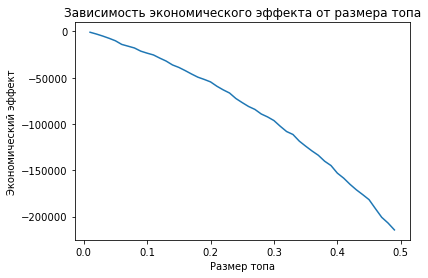

In [163]:
plt.plot(tops, effect_top)
plt.xlabel("Размер топа")
plt.ylabel("Экономический эффект")
plt.title("Зависимость экономического эффекта от размера топа")

##### Если непредвиденные расходы возрастут до 200 (IOC = 500, PR = 200, PA = 0.5, UC = 200, PUC = 0.3), то применять модель становится невыгодно.

### 5.

Оцените изменение экономического эффекта от проведения кампании по удержанию при увеличении качества модели на 1%? На 3%? При ответе на вопрос укажите, по какой метрике вы оцениваете качество.

Представим, что нам удалось повысить полноту модели на 1% (т.е. используем метрику recall). Для этого вычислим сначала сколько объектов класса "отток" правильно определяет наша модель и посмотрим на сколько нам надо увеличить этот показатель, чтобы полнота модели выросла на 1%.

In [248]:
y_predict = xgboost_classifier.predict(X_test)

In [249]:
data2 = pd.DataFrame()
data2['Predict'] = y_predict
data2['Fact'] = list(y_test)

In [250]:
tab_cross = pd.crosstab(data2.Predict, data2.Fact)
tab_cross  

Fact,-1.0,1.0
Predict,,
-1.0,2458,517
1.0,927,2867


In [251]:
recall = tab_cross.iloc[1,1]/(tab_cross.iloc[1,1]+tab_cross.iloc[0,1])
round(recall,3)

0.847

In [252]:
#Проверим, верно ли мы посчитали recall 
metrics.recall_score(y_test, y_predict)

0.8472222222222222

Из вычислений выше видим, что модель верно относит в классу "отток" ("1") 2867 объектов из 3384. Полнота при этом равна 85%. Чтобы увеличить этот показатель до 86%, необходимо, чтобы модель относила к классу "отток" 2910 реальных объектов первого класса (вычисления через обычную пропорцию). Смоделируем увеличение качества модели на 1 процент: у 43 объектов, которые модель отнесла к классу "-1", а по факту они относятся к "1", поменяем вероятность на 0.9. То есть представим, что якобы наша модель верно спрогнозировала отнесение данных объектов к классу "1" с высокой вероятностью. 

In [355]:
j=0
for i in range(data.shape[0]):
    if (data.iloc[i, 1]<0.5) & (data.iloc[i, 0]==1) & (j<43):
        data.iloc[i, 1]=0.9
        j+=1

In [356]:
data.sort_values('Prob_Predict', inplace = True, ascending=False)

In [357]:
data['Predict'] = 0
for i in range(data.shape[0]):
    if data.iloc[i,1]>0.5: data.iloc[i,2]=1
    else: data.iloc[i,2]=-1

In [358]:
tab_cross2 = pd.crosstab(data.Predict, data.Fact)
tab_cross2  

Fact,-1.0,1.0
Predict,,
-1,2458,474
1,927,2910


In [336]:
metrics.recall_score(data.Fact, data.Predict)

0.8599290780141844

Выше проверили себя по таблице сопряженности и по метрике recall, видим, что повысили качество до 86%

Text(0.5, 1.0, 'Зависимость экономического эффекта от размера топа')

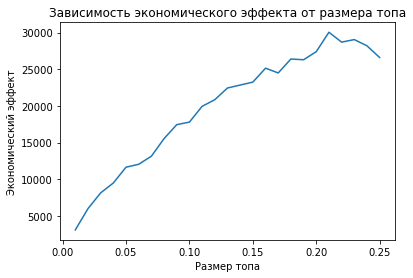

In [359]:
IOC = 500
PR = 200
PA = 0.5

tops = np.arange(0.01, 0.26, 0.01)
effect_top = []
for top in tops:
    effect_top.append(effect(top, IOC, PR, PA, data))
    
plt.plot(tops, effect_top)
plt.xlabel("Размер топа")
plt.ylabel("Экономический эффект")
plt.title("Зависимость экономического эффекта от размера топа")

##### Из графика видно, что за счет увеличения качества модели на 1% , размер топа снизился ориентировочно до 22% и размер экономического эффекта вырос до 30000р.

Попробуем увеличить полноту модели на 3% (по сравнению с изначальной оценкой).

Аналогично расчетам выше, вычисляем, что к классу "1" модель должна отнести 2978 объектов, чтобы качество выросло до 88%. То есть еще 68 объектов нужно искусственно перевести в первый класс.

In [362]:
j=0
for i in range(data.shape[0]):
    if (data.iloc[i, 1]<0.5) & (data.iloc[i, 0]==1) & (j<68):
        data.iloc[i, 1]=0.9
        j+=1

In [363]:
data.sort_values('Prob_Predict', inplace = True, ascending=False)

In [364]:
data['Predict'] = 0
for i in range(data.shape[0]):
    if data.iloc[i,1]>0.5: data.iloc[i,2]=1
    else: data.iloc[i,2]=-1

In [365]:
tab_cross3 = pd.crosstab(data.Predict, data.Fact)
tab_cross3 

Fact,-1.0,1.0
Predict,,
-1,2458,406
1,927,2978


In [366]:
metrics.recall_score(data.Fact, data.Predict)

0.8800236406619385

Text(0.5, 1.0, 'Зависимость экономического эффекта от размера топа')

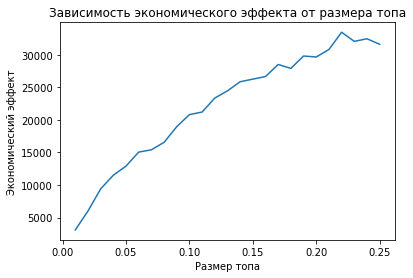

In [367]:
IOC = 500
PR = 200
PA = 0.5

tops = np.arange(0.01, 0.26, 0.01)
effect_top = []
for top in tops:
    effect_top.append(effect(top, IOC, PR, PA, data))
    
plt.plot(tops, effect_top)
plt.xlabel("Размер топа")
plt.ylabel("Экономический эффект")
plt.title("Зависимость экономического эффекта от размера топа")

##### Из графика видим, что при увеличении качества модели на 3%, размер топа составил порядка 23% и при этом прибыль выросла уже примерно до 34000р.

## 6

Как вы думаете, является ли экономически оправданным вложение средств в улучшение качества модели? На сколько нужно улучшить модель, чтобы это качественно сказалось на экономическом эффекте от удержания?

Увеличение качества модели потребует вложения дополнительных средств. Возьмем результаты последней модели из предыдущего пункта (качество изначальной модели повысили на 3% и экономический эффект достиг 34000р.). При увеличении расходов на одного клиента даже на 10 руб. (сделаем PR = 210) видим, что экономический эффект резко снижается (с 34000 до 18500):

Text(0.5, 1.0, 'Зависимость экономического эффекта от размера топа')

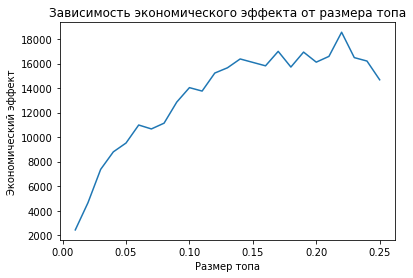

In [371]:
IOC = 500
PR = 210
PA = 0.5

tops = np.arange(0.01, 0.26, 0.01)
effect_top = []
for top in tops:
    effect_top.append(effect(top, IOC, PR, PA, data))
    
plt.plot(tops, effect_top)
plt.xlabel("Размер топа")
plt.ylabel("Экономический эффект")
plt.title("Зависимость экономического эффекта от размера топа")

##### Следовательно ответ на вопрос зависит от того какова цена за улучшение качества модели. Видно, что экономический эффект значительно увеличивается при малейшем повышении качества, но также и значительно снижается при небольшом увеличении расходов. Кажется, что вложение средств в существенное повышение качества модели с выбранными параметрами не совсем экономически оправдано, т.к. в исходной модели доход составил порядка 27000р, а после увеличения качества только на 3% и увеличения расхода на одного клиента на 10руб, доход составил лишь 18500р.